---
title: Comparing NLDAS2 to NLDAS3
description: NLDAS3 is the next generation version of NLDAS2, and addresses some well known issues with NLDAS2 such as the blending issues on the US/Canada border.
author: Rishi Anand
date: July 26, 2024
execute:
   freeze: true
---

In [1]:
# import libraries
from matplotlib import pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from __future__ import print_function
import boto3
import s3fs
import rioxarray
import rasterio
from rasterio.io import MemoryFile
import os
import tempfile
import shutil

#### The files are stored in Project VEDA's AWS cloud storage platform, so they can be accessed easily with the correct credentials from any environment.

In [2]:
# Set up global variables

# Indicates the folder where the NLDAS files are found in the EIS folder of the s3 bucket
directory2='NLDAS2MonthlyData'
directory3='NLDAS3MonthlyData'

# Define the Lat/Long boundaries of the data for rescaling later
nldasExtent = {
    "x0":-169.0,
    "xn":-52.0,
    "y0":7.0,
    "yn":72.0
}

#Temporary credentials, get them from Rishi Anand


#### The data needs to be rescaled to work properly, as there was an encoding error related to one of the axes.

In [3]:
# This function is used to generate rescaled axes, and will be used to convert the NLDAS data to Lat/Long axes
def scaleAxes(x, y, x0, xn, y0, yn):
    newX = np.array(x)
    newY = np.array(y)
    newX = newX * (xn-x0)/len(x)
    newY = newY * (yn-y0)/len(y)
    medX = np.median(newX)
    medY = np.median(newY)
    newX = newX-medX+((x0+xn)/2)
    newY = newY-medY+((y0+yn)/2)
    
    return [newX, newY]

# This function reads the files from directory starting with initYear and processes yearsToProcess years
def getNLDASFilesForYrRange(initYear=2019, yearsToProcess=1, folder="NLDAS3MonthlyData"):
    print("Reading stored files...")
    # The returned list of data
    results = []
    # A list of dates associated with each datapoint, will be returned alongside results
    dates = []

    fs = s3fs.S3FileSystem(anon=False, 
                           key=credentials[''], 
                           secret=credentials[''],
                           token=credentials[''],
                           client_kwargs={
                           'endpoint_url':'https://s3.us-west-2.amazonaws.com'
                           })
    aws_url = 's3://veda-data-store-staging/'
    
    # Go through the files month by month
    for month in range(int(12 * yearsToProcess)):
        
        #Convert from raw month into year and month of year (Jan == 01)
        year = month//12+initYear
        monthOfYear = month%12+1
        if month%12==0:
            print(year)
        
        # Format the year and month of year to the standard filename format
        yrMnth = str(year) + str(monthOfYear).zfill(2)
        nc = xr.open_dataset(fs.open(aws_url+"EIS/"+folder+"/LIS_HIST_"+yrMnth+".nc")) # reading the nc file and creating Dataset
        nc = nc.set_coords(("lat", "lon")).drop_vars(['latitude', 'longitude'])
        
        # Rescalin the axes to Lat/Long
        axes = scaleAxes(nc["longitude"], nc["latitude"], nldasExtent["x0"], nldasExtent["xn"], nldasExtent["y0"], nldasExtent["yn"])
        nc["latitude"] = axes[1]
        nc["longitude"] = axes[0]
        results.append(nc)
    
    #Iterate through all used dates as datetimes and add them to dates
    nextM = datetime.date(initYear, 1, 1)
    end = datetime.date(initYear+yearsToProcess-1, 12, 1)    

    while nextM <= end:
        dates.append(nextM)
        nextM += relativedelta(months=1)
    
    # Return generated data and corresponding dates in a dict
    return {
        "data":results,
        "dates":dates
    }

#### To make sure that differentiation between datasets is easy, the NLDAS2 and NLDAS3 data are stored in separate locations, but both are accessible on the same server.

In [4]:
#Grab the data to analyze
#data2 = getNLDASFilesForYrRange(initYear=2019, yearsToProcess=2, folder=directory2)
#data3 = getNLDASFilesForYrRange(initYear=2019, yearsToProcess=2, folder=directory3)
# Get a smaller sample to play with
sample2 = getNLDASFilesForYrRange(initYear=2019, yearsToProcess=1, folder=directory2)["data"]
sample3 = getNLDASFilesForYrRange(initYear=2019, yearsToProcess=1, folder=directory3)["data"]

Reading stored files...
2019
Reading stored files...
2019


#### Notice the differences in extent and specificity in the new version.

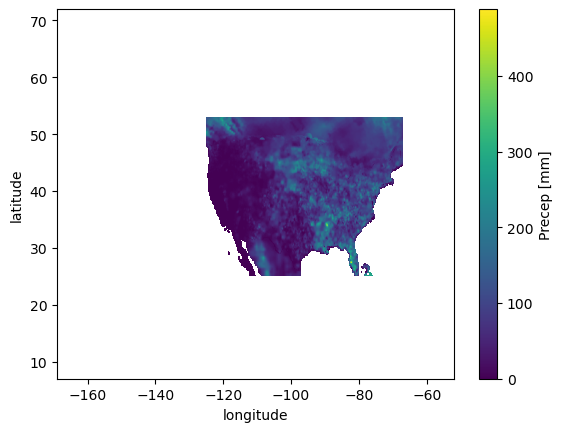

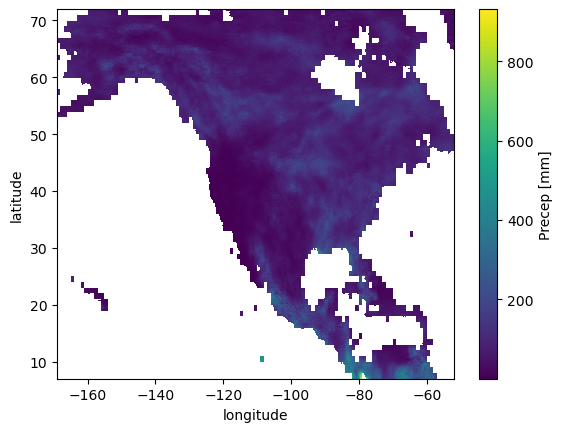

In [5]:
# Look at one of the raw pieces of data
sample2[6]["Precep"].plot()
plt.show()
sample3[6]["Precep"].plot()